In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from matplotlib import pyplot as plt
from datetime import datetime   

In [81]:
#Definicion de funciones

#Extraemos los datos  de Yahoo Finances, por el momento unicamente nos interesa el precio de cierre
def extract_date_yf(etiqueta,start_data,end_data,periocidad):

    df_aux = yf.download(etiqueta,start=start_data,end=end_data, interval = periocidad)
    return pd.DataFrame(df_aux['Close'])


#Creamos la primera estrategia y buscaremos evaluar su rentabilidad acumulada
def primera_estrategia(etiqueta,start_data,end_data,periocidad):

    #Extraccion de los datos
    df = extract_date_yf(etiqueta,start_data,end_data,periocidad)
    

    #Creacion de medias moviles (SECCION DE LOS INDICADORES)
    df['mv_rapida'] = df['Close'].rolling(30).mean()
    df['mv_lenta'] = df['Close'].rolling(60).mean()


    #Definimos una variable llamada "POSICION" que determina si compramos o vendemos
    df['posicion'] = np.nan

    df.loc[(df['mv_rapida'] > df['mv_lenta']) , 'posicion' ] = 1
    df.loc[(df['mv_rapida'] < df['mv_lenta'])  , 'posicion']  = -1


    #Porcentaje de variacion
    df['pct'] = df['Close'].pct_change()

    #Retorno obtenido en caso de seguir la posicion del dia anterior
    df['return'] = df['pct'] * df['posicion'].shift(1)

    #Retornamos el dataframe con todos los datos
    return df


#Mostramos el grafico del precio con los indicadores, el grafico de las posiciones abiertas y cerradas y las ganancias/perdidas acumuladas
def graficos(df):

    #==== GRAFICO NORMAL
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre')
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9')
    plt.plot(df['mv_lenta'], color='red', label='MV de 18')


    plt.legend(['Precio de cierre','MV rapida','MV lenta'])
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE POSICIONES ABIERTAS Y CERRADAS 

    #Lo que se hace aca es obtener los indices de cada posicion que tiene marcado 1 y -1
    idx_open = df.loc[df["posicion"] == 1].index
    idx_close = df.loc[df["posicion"] == -1].index


    # Configuración del estilo y tamaño
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))

    #Configuracion de lineas punteadas - Como tenemos los indice de los 1 y -1, para buscar la Y usamos loc con el indice y el precio de cierre 
    plt.scatter(idx_open, df.loc[idx_open]['Close'], color ="green", marker="^")
    plt.scatter(idx_close, df.loc[idx_close]['Close'], color ="red", marker="v")


    #Configuracion de cada linea
    plt.plot(df['Close'], color="white", label='Precio de cierre' , alpha = 0.35)
    plt.plot(df['mv_rapida'], color='yellow', label='MV de 9', alpha = 0.35)
    plt.plot(df['mv_lenta'], color='red', label='MV de 18',alpha = 0.35)

    plt.legend()
    plt.xlabel("Frecuencia Diaria")
    plt.ylabel("Precio")

    plt.show()


    #=== GRAFICO DE VARICIONES ACUMULADA
    plt.style.use('dark_background')
    plt.figure(figsize=(15,8))
    plt.plot(df['return'].cumsum() * 100)
    plt.show()
    




<H3>Indice sortino(IS):</H3>

* Si IS < 0, el promedio de las variaciones es negativo
* Si  0 < IS < 1, no es recomendable. Ya que el promedio no supera la desviacion estandar negativa.
* Si IS > 1, se recomienda invertir, ya que el promedio de los valores supera la variacion negativa (esto porque hay mas valores positivos).


In [82]:

def indice_sortino(df):

    #Obtencion de media y varianza
    u = df['pct'].mean()
    var = df['pct'][df['pct'] < 0].std() #Teniendo en cuenta las perdidas

    #Multiplicamos por 252 ya que es la cantidad de dias que la bolsa esta abierta en el año
    ind_sortino = np.sqrt(252)*(u / var)

    print(f"Indice Sortino: {ind_sortino}")

    
    """# Configuración del estilo y tamaño
    plt.style.use('dark_background')
    
    #Estudiamos la distancia de los datos respecto a la media, y la dispersion
    plt.figure(figsize=(10,10))
    plt.scatter(range(len(df['pct'])),df['pct'], alpha=0.35)

    #Graficamos el rango de la varianza, y la media
    plt.axhline(y = u - df['pct'].std(), color = "green", linestyle='dashed',label = "Desviacion de todos los datos")
    plt.axhline(y = u, color = "red", linestyle='dashed')
    plt.axhline(y = -(u-df['pct'].std()),color = "green", linestyle='dashed')

    #Desviacion de los valores negativos
    plt.axhline(y = u - var, color = "purple", linestyle='dashed',label = "Desviacion de los rendimientos negativos")
    plt.axhline(y = -(u-var),color = "purple", linestyle='dashed')

    plt.legend()
    plt.show()"""

<H3> Indice Beta(IB): </h3>

Nos habla del nivel de relacion que existe entre el mercado y una accion en particular. Nos indica cuanto varia una accion
en base a la variacion que sufre el mercado. 

Ejemplo: Si IB = 0.7, quiere decir que si el MERCADO se mueve un 1%, la accion varia un 0.7%,

*  Si IB > 1, no se recomienda la accion. Es mas volatil que el mercado.
* Si IB < 1, se recomienda porque la accion varia menos que el mercado.

In [83]:
def indice_beta(df,fecha_inicio,fecha_fin,frecuencia):

    #Extraemos los datos del SP500 - Calculamos los porcentaje de variaciones
    df_sp500 = extract_date_yf("^GSPC",fecha_inicio,fecha_fin,frecuencia)
    df_sp500['pct'] = df_sp500['Close'].pct_change(1)


    #Concatenamos los porcentajes de la accion y del indice de mercado
    var = pd.concat((df['pct'],df_sp500['pct']),axis=1).dropna()

    """"
    rowvar = False, ya que esto nos genera una comparacion por fila. Necesitamos una 
    Comparacion de toda la columna con la otra.
    
    Obtendremos una matriz de 4 elementos:
        - elemento (0,0) y (1,1) son VARIANZAS
        - elemento (0,1) y (1,0) son la COVARIANZA --> Este es el objetivo
    """
    matriz_varianzas = np.cov(var,rowvar=False)
    
    #Obtenemos de la matriz la covarianza. Y la Varianza del activo
    covarianza_activos = matriz_varianzas[1,0]

    #Indice beta
    ib = covarianza_activos / np.var(df['pct'])

    print(f"El indice BETA es: {ib:.3f}")

    return ib


<h3> Valor CAMP </h3>

Con este valor tratamos de definir el nivel de retorno en base al riesgo/beneficio asumido respecto al mercado.

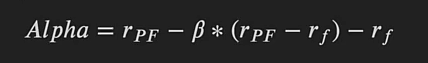

Se simplicada quedando: r(pf) - b * r(pf) = r(pf) * (1-b)

* r(pf) es el rendimiento esperado del mercado, que es el promedio de las variaciones porcentuales a lo largo del año.
* b es beta, que mide la relacion entre activo y mercado.

El valor se interpeta: 

* Si el valor es mayor a 0. Quiere decir que la rentabilidad obtenida es mayor asumiendo el mismo riesgo que el mercado.
* Si es menor a 0. Quiere decir que la rentabilidad obtenida es menor, asumiendo el mismo riesgo que el mercado.

In [84]:
def valor_camp(df,beta):

    #Obtencion de la media de las variaciones porcentuales del activo
    u = df['pct'].dropna().mean()

    #Se multiplica por 252 por una cuestion de anualizar la formula
    alpha = (252 * u * (1 - beta)) * 100

    print(f"El valor CAMP es: {alpha:.3f}%")

    return alpha



In [85]:
#Estrategia que aplica la apertura de posiciones y su mantenimiento en base a un stoploss, y profit.

"""
Probramos establecer "estados" para la posiciones.
2 = cerrada
1 = abierta o manteniendo una posicion 
0 = no hacer nada
"""


def estrategy_profit_stoploss(etiqueta,start_data,end_data,periocidad,stoploss,profit):

    #Extraccion de los datos
    df = extract_date_yf(etiqueta,start_data,end_data,periocidad)

    #Creacion de medias moviles (SECCION DE LOS INDICADORES)
    df['mv_rapida'] = df['Close'].rolling(30).mean()
    df['mv_lenta'] = df['Close'].rolling(60).mean()
    
    #Eliminacion de valores nulos
    df = df.dropna()

    #Lista que contiene la posicion. Valores explicados arriba
    lista_posicion = list()


    #Porcentaje de perdida considerado para la venta del activo
    precio_stoploss = None


    #Banderas de compra | venta
    compra = False

    #valores stoplos
    list_stoploss = list()
    for index,raw in df.iterrows():

        if raw['mv_rapida'] > raw['mv_lenta']: #Si la mv rapida atraviesa la lenta - comprar
            
            if compra == False:
        
                #Definimos el stoploss en base al precio
                precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                list_stoploss.append(precio_stoploss)
                #Realizamos una compra, ahora queda cortar con el stoploss
                compra = True

                #Agregamos una posicion
                lista_posicion.append(1)

            else:# -- Se ejecuta solo si ya se realizo una compra

                try:
                    if raw['Close'] <= precio_stoploss: #--> Si el precio pasa el stoploss se vende
                        lista_posicion.append(2) #--> posicion de venta
                        compra = False #--> Habilitamos la compra nuevamente
                        precio_stoploss = None
                    else:
                        lista_posicion.append(0) #--> Si no. Se mantiene posicion neutral
                        precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                        list_stoploss.append(precio_stoploss)
                except:
                    lista_posicion.append(0)
                    precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                    list_stoploss.append(precio_stoploss)

        else:#Si la MV lenta esta por encima de la lenta

                try:
                    if raw['Close'] <= precio_stoploss:# VENDEMOS solo si se produjo una compra
                        lista_posicion.append(2) #--> Vendemos
                        compra = False#--> Habilitamos la compra nuevamente
                        
                        #Anulamos el stoploss hasta la siguiente orden de compra
                        precio_stoploss = None

                    else: #Si no pasa el stoploss - mantener neutral
                        lista_posicion.append(0)
                        precio_stoploss = raw['Close'] * (1 - (stoploss/100))
                        list_stoploss.append(precio_stoploss)
                except:   #Si pasa el stoploss mantener 
                        lista_posicion.append(0)  
                        precio_stoploss = raw['Close'] * (1 - (stoploss/100)) 
                        list_stoploss.append(precio_stoploss)         


    print("tamaño de lista_posicion:",len(lista_posicion))


    #Definimos una variable llamada "POSICION" que determina si compramos o vendemos
    df['posicion'] = lista_posicion    

    #Porcentaje de variacion
    df['pct'] = df['Close'].pct_change()*100


    return df,list_stoploss


"""
        else:#Caso contrario - No comprar o vender si compramos

                try:
                    if raw['Close'] <= precio_stoploss:
                        lista_posicion.append(2) #--> Vendemos
                        compra = False
                        
                        #Anulamos el stoploss hasta la siguiente orden de compra
                        precio_stoploss = None

                    else:
                        lista_posicion.append(0)
                except:
                        lista_posicion.append(0)

"""


#Visualizaciones de prueba
def visualizacion_prueba(df,lista_stoploss):

    tamaño_scater = len(df)

    plt.style.use('dark_background')
    plt.figure(figsize=(20,20))

    #Precio normal
    plt.plot(df['Close'], color = "white", label = "Precio de cierre", alpha = 0.35)
    plt.plot(df['mv_rapida'], color = "yellow", label = "Media rapida", alpha = 0.35)
    plt.plot(df['mv_lenta'], color = "red", label = "Media lenta", alpha = 0.35)

    #=== Puntos de compra y venta

    #Recorremos las posiciones y cargamos en la lista los colores asignados a cada posicion
    lista_colores = []

    for posicion in df['posicion']:
         
        #if posicion == 0: #No se hizo nada
        #    lista_colores.append("blue")
        if posicion == 1:
            lista_colores.append("green")
        elif posicion == 2:
            lista_colores.append("red")
        

    plt.scatter(df.index[df['posicion'] != 0],df['Close'][df['posicion'] != 0], c=lista_colores,label = "Verde: compra | azul: Neutral | rojo: Venta ")

    plt.legend()

    plt.show()

    plt.scatter(range(0,len(lista_stoploss)),lista_stoploss)

<H1> MAIN DE EJECUCION </H1>

In [86]:
fecha_actual = end_data = str(datetime.now().year) + "-" + str(datetime.now().month) + "-" + str(datetime.now().day)

fecha_inicio = "2020-01-01"
#fecha_fin = "2021-01-01"
frecuencia = "1d"
df,lista_stoploss = estrategy_profit_stoploss("MELI",fecha_inicio,fecha_actual,frecuencia,10,5)   

print(df[df['posicion'] == 1])

df_auz = df
#Prueba
for index,row in df_auz.iterrows():

    
    if row['posicion'] == 0:
        posicion = "nada"
    if row['posicion'] == 1:
        posicion = "compra"
    if row['posicion'] == 2:
        posicion == "venta"

    print(f"""
        Variacion con el precio anterior {row['pct']:.2f} - Precio: {row['Close']} - Posicion: {posicion}
        MV LENTA: {row['mv_lenta']} - MV RAPIDA: {row['mv_rapida']}
""")


[*********************100%%**********************]  1 of 1 completed

tamaño de lista_posicion: 968
                  Close    mv_rapida     mv_lenta  posicion       pct
Date                                                                 
2020-05-11   781.109985   585.397004   583.428336         1 -0.434665
2020-11-10  1226.030029  1244.633325  1175.432664         1 -7.867165
2022-05-06   927.549988  1097.606667  1079.413332         1  1.569175
2022-05-10   774.440002  1069.404667  1068.278665         1  0.447478
2022-08-05  1024.810059   749.774335   744.931501         1 -0.968265

        Variacion con el precio anterior nan - Precio: 471.42999267578125 - Posicion: nada
        MV LENTA: 621.1831675211589 - MV RAPIDA: 581.45966796875


        Variacion con el precio anterior 0.39 - Precio: 473.2900085449219 - Posicion: nada
        MV LENTA: 618.9015009562174 - MV RAPIDA: 572.7356679280599


        Variacion con el precio anterior 3.23 - Precio: 488.5799865722656 - Posicion: nada
        MV LENTA: 616.9145009358724 - MV RAPIDA: 564.740000406901


  

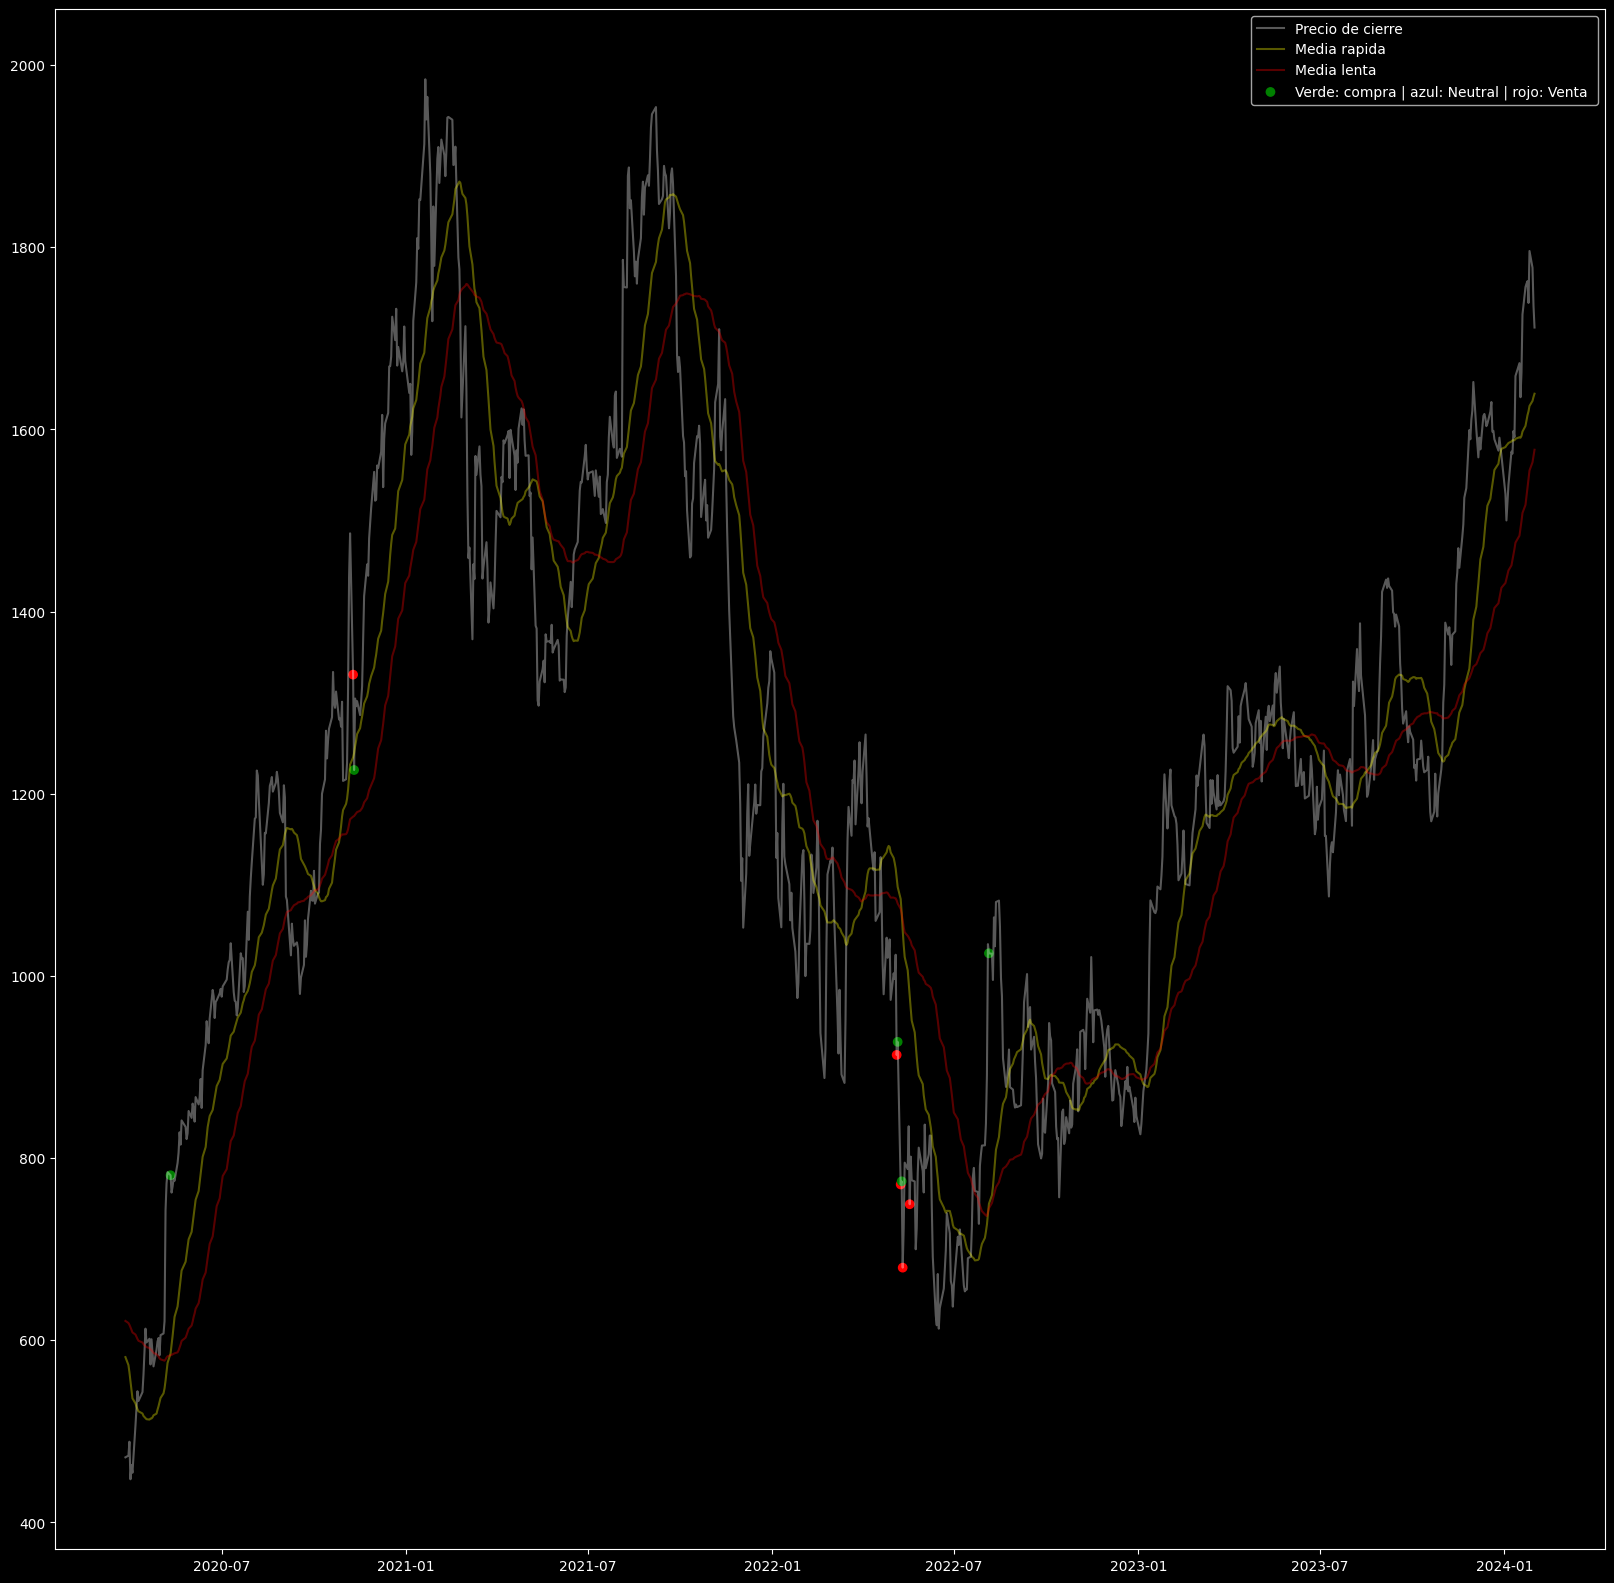

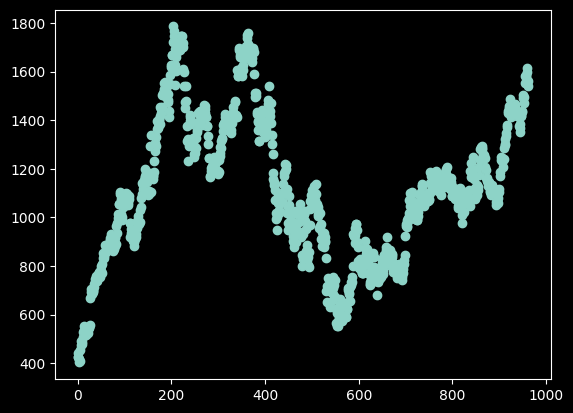

In [87]:
visualizacion_prueba(df,lista_stoploss)